# Mixed models for repeated records

This is a frequent case of longitudinal data: repeated observations
taken on individuals. The objective is to study the change of the target
variable over time (multiple measurements) and the factors (explanatory
variables) that influence this change. Observations that belong to the
same individual (patient, animal, plant, group) tend to be more similar
than observations from different individuals, and this covariance need
to be accounted for in the model of analysis.

Repeated-record data are a special case of hierarchical data, where
observations are nested within levels (e.g. milk yield measurements
within cow, or cows within herd, fish catches within region etc.).

-   $y_{ij}$: target variable measured on individual *i* at time *j*
-   $\Sigma$: symmetric covariance matrix between individuals

## Cow data

Dataset on dairy cows:

-   NID: cow ID
-   dtn: birthdate
-   dtp: calving date
-   dtcf: milk testing day
-   aua: herd
-   nl: parity
-   milk: kg/day
-   fat %
-   protein %
-   SCC: somatic cells count
-   fat kg
-   protein kg

In [ ]:
import numpy as np ## arrays
import pandas as pd ## dataframes
import seaborn as sns ## plots
import statsmodels.api as sm ## statistical models
import matplotlib.pyplot as plt ## plots

In [ ]:
url="https://raw.githubusercontent.com/filippob/longitudinal_data_analysis/refs/heads/main/data/cows/esempio.csv"
cows = pd.read_csv(url)

cows

,NID,dtn,dtp,dtcf,aua,nl,latte,grasso,prot,scs,kg_grs,kg_prt
0,V1,25/12/06,26/07/2014,07/01/2015,2781016,6,22.7,3.89,3.17,71,0.88303,0.71959
1,V1,25/12/06,02/07/2015,07/06/2016,2781016,7,20.8,4.43,3.56,266,0.92144,0.74048
2,V1,25/12/06,26/07/2014,10/02/2015,2781016,6,22.9,3.58,3.20,86,0.81982,0.73280
3,V1,25/12/06,02/07/2015,12/01/2016,2781016,7,22.9,4.41,3.66,591,1.00989,0.83814
4,V1,25/12/06,02/07/2015,16/02/2016,2781016,7,19.9,4.57,3.25,1444,0.90943,0.64675
...,...,...,...,...,...,...,...,...,...,...,...,...
495,V37,22/10/12,11/03/2016,13/10/2016,2773233,2,19.9,4.34,3.45,436,0.86366,0.68655
496,V37,22/10/12,11/03/2016,18/11/2016,2773233,2,18.6,3.58,3.99,255,0.66588,0.74214
497,V37,22/10/12,10/03/2015,20/07/2015,2773233,1,15.0,3.17,3.06,42,0.47550,0.45900
498,V37,22/10/12,11/03/2016,21/03/2016,2773233,2,30.2,4.38,3.73,172,1.32276,1.12646


Repeated records per individual (cow):

In [ ]:
cows['NID'].value_counts().head()

,count
NID,
V36,26
V12,24
V17,24
V7,24
V4,23


In [ ]:
cows['NID'].value_counts().value_counts().sort_index(ascending=False)

,count
count,
26,1
24,3
23,3
22,1
21,1
20,1
19,2
18,1
17,1


### Preprocessing

We encode dates as date data (not strings); in *Python* we can use the `Pandas` function `to_datetime` to convert strings to dates (specifying the input date format):

In [ ]:
cows.dtypes

,0
NID,object
dtn,object
dtp,object
dtcf,object
aua,int64
nl,int64
latte,float64
grasso,float64
prot,float64
scs,int64


In [ ]:
cows['date'] = pd.to_datetime(cows['dtcf'], format='%d/%m/%Y')
cows['date']

,date
0,2015-01-07
1,2016-06-07
2,2015-02-10
3,2016-01-12
4,2016-02-16
...,...
495,2016-10-13
496,2016-11-18
497,2015-07-20
498,2016-03-21


Few cows with late parities, hence we group them:

In [ ]:
cows['nl'].value_counts()

,count
nl,
1,132
2,107
3,98
4,65
5,52
6,28
7,14
8,4


In [ ]:
# Define the breaks and labels
bins = [0, 1, 2, 3, 4, 5, np.inf]
labels = ["1", "2", "3", "4", "5", "6+"]

# Apply cut to create 'parity' column
cows['parity'] = pd.cut(cows['nl'], bins=bins, labels=labels, right=True)

In [ ]:
cows['parity'].value_counts()

,count
parity,
1,132
2,107
3,98
4,65
5,52
6+,46


Then we select the variables of interest.

-   target is milk kg / day
-   time is the test-day date
-   systematic effects are herd and parity (regrouped as above)

In [ ]:
cows_reduced = cows[['NID','date','aua','parity','latte']]
cows_reduced.rename(columns={'aua': 'herd', 'latte': 'milk'}, inplace=True)
cows_reduced

<ipython-input-10-5642aa5e8d6f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cows_reduced.rename(columns={'aua': 'herd', 'latte': 'milk'}, inplace=True)


,NID,date,herd,parity,milk
0,V1,2015-01-07,2781016,6+,22.7
1,V1,2016-06-07,2781016,6+,20.8
2,V1,2015-02-10,2781016,6+,22.9
3,V1,2016-01-12,2781016,6+,22.9
4,V1,2016-02-16,2781016,6+,19.9
...,...,...,...,...,...
495,V37,2016-10-13,2773233,2,19.9
496,V37,2016-11-18,2773233,2,18.6
497,V37,2015-07-20,2773233,1,15.0
498,V37,2016-03-21,2773233,2,30.2


## EDA

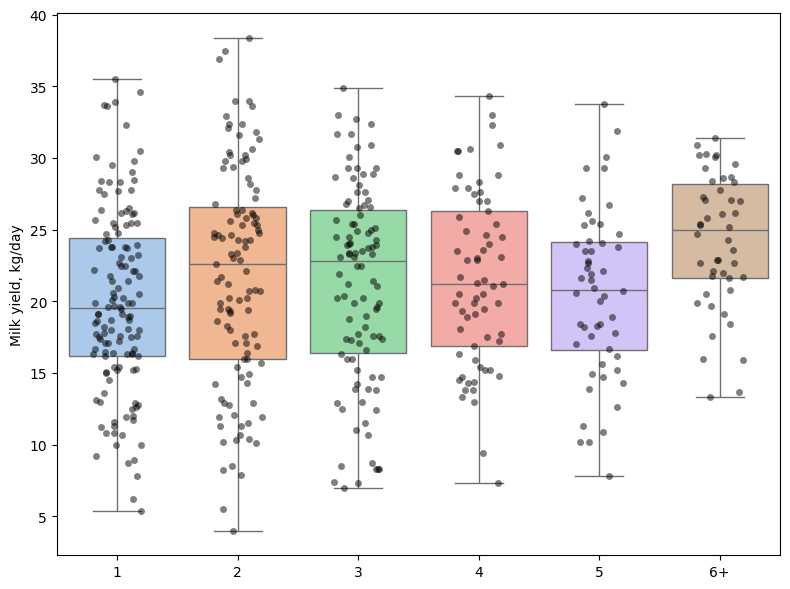

In [ ]:
plt.figure(figsize=(8, 6))

# Boxplot with fill by parity
sns.boxplot(data=cows_reduced, x='parity', y='milk', hue='parity', dodge=False, palette='pastel')

# Jittered data points
sns.stripplot(data=cows_reduced, x='parity', y='milk',
              color='black', alpha=0.5, jitter=0.2)

# Remove legend (similar to guides(fill = "none"))
plt.legend([],[], frameon=False)

# Labels
plt.xlabel("")
plt.ylabel("Milk yield, kg/day")
plt.title("")

plt.tight_layout()
plt.show()

##### Individual cow plots

In [ ]:
## to suppress warnings with plots

import warnings
warnings.filterwarnings('ignore')

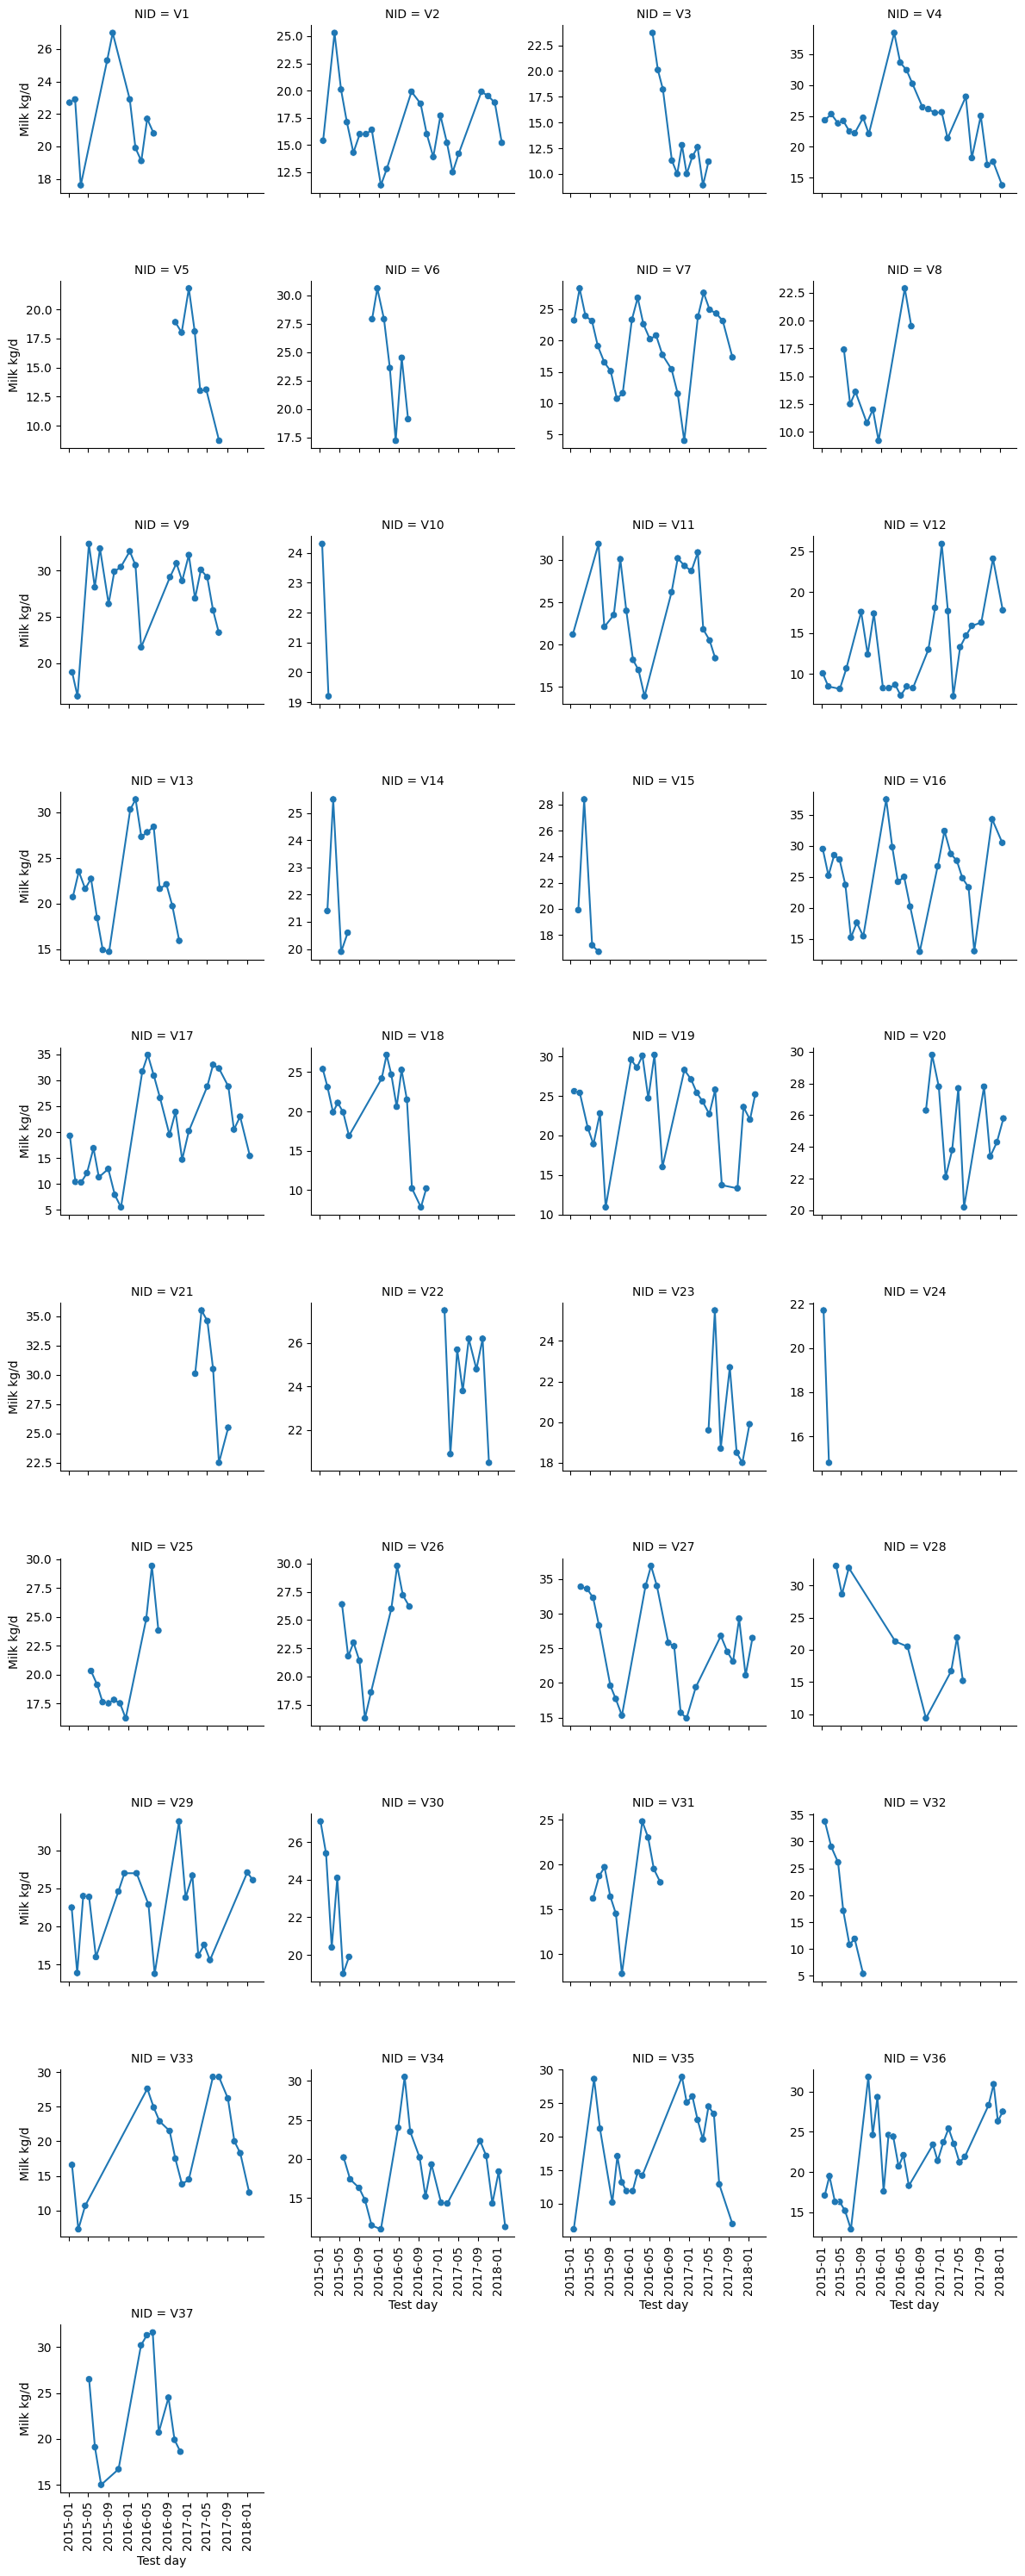

In [ ]:
# Convert NID to string to treat it as a categorical variable (like factor in R)
cows_reduced['NID'] = cows_reduced['NID'].astype(str)

# Create the FacetGrid
g = sns.FacetGrid(cows_reduced, col="NID", col_wrap=4, height=3, sharey=False)

# Map both points and lines
g.map_dataframe(sns.lineplot, x="date", y="milk", hue="NID", legend=False)
g.map_dataframe(sns.scatterplot, x="date", y="milk", hue="NID", legend=False)

# Rotate x-axis labels
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# Set axis labels
g.set_axis_labels("Test day", "Milk kg/d")

# Tight layout
plt.tight_layout()
plt.show()

By herd:

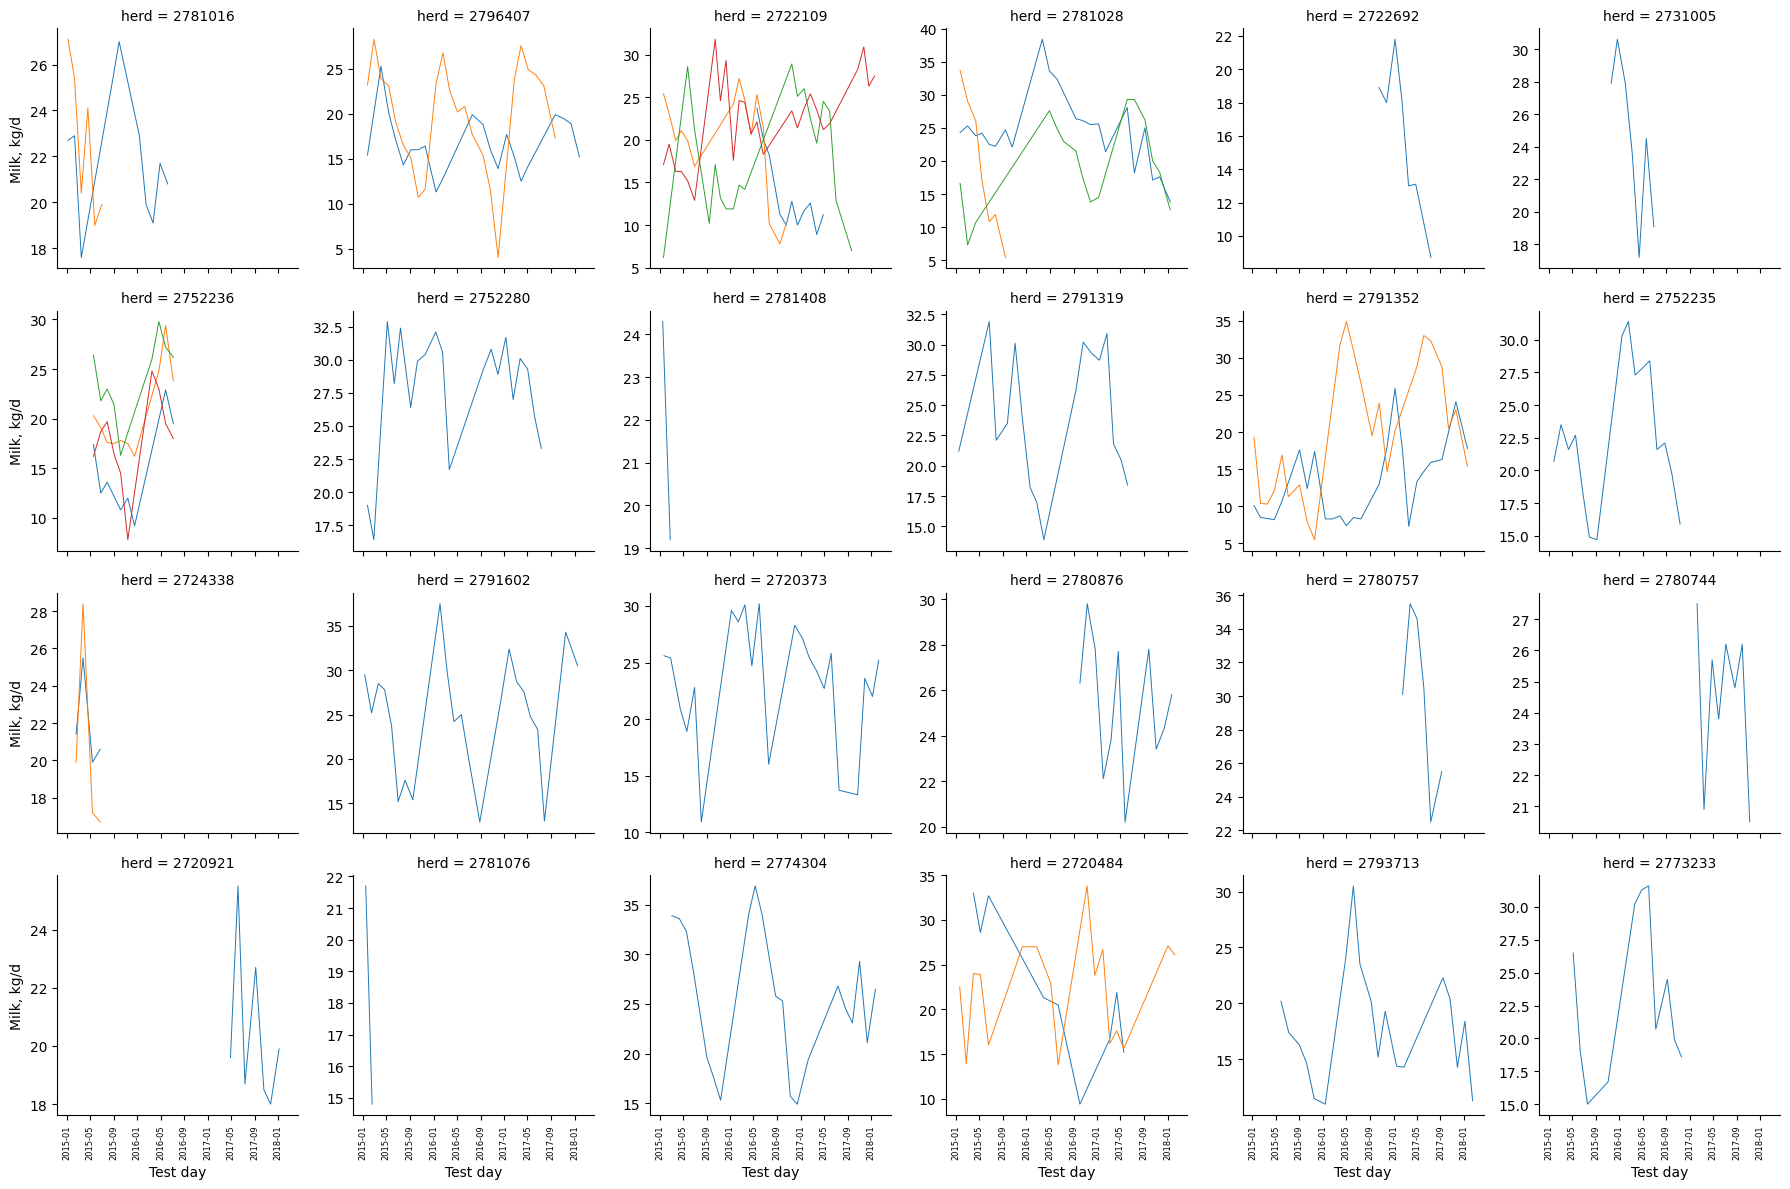

In [ ]:
cows_reduced['NID'] = cows_reduced['NID'].astype(str)
cows_reduced['herd'] = cows_reduced['herd'].astype(str)

# Set up FacetGrid by herd
g = sns.FacetGrid(cows_reduced, col="herd", col_wrap=6, height=3, sharey=False)

# Map cow-level lines
g.map_dataframe(
    sns.lineplot,
    x="date",
    y="milk",
    hue="NID",
    units="NID",
    estimator=None,
    lw=0.7,
    legend=False
)

# Rotate x-axis labels and adjust font size
for ax in g.axes.flat:
    ax.tick_params(axis='x', labelrotation=90, labelsize=6)

# Set axis labels
g.set_axis_labels("Test day", "Milk, kg/d")

plt.tight_layout()
plt.show()


### Repeatability model

$$
\mathbf{y} = \mathbf{Xb} + \mathbf{Wpe} + \mathbf{e}
$$

We have here a **permanent environment effect** (**pe**) that is linked to the fact that we have repeated measurements on the same subjects. These repeated measurements share a covariance linked to the subject they belong to.

This covariance translates to a component of the total variance of the target variable:

$$
Var(y) = Var(pe) + Var(e)
$$

Compared to simpler linear models, here we have one additional variance component besides the residual variance (i.e. variance of the target variable adjusted for the systematic effects).

1. estimate variance components and repeatability
2. get predictions of individual records (fitted values)

In [ ]:
# Ensure correct data types
cows_reduced['parity'] = cows_reduced['parity'].astype('category')
cows_reduced['herd'] = cows_reduced['herd'].astype('category')
cows_reduced['NID'] = cows_reduced['NID'].astype('category')

# Mixed Effects Model
md = sm.formula.mixedlm("milk ~ parity + herd", cows_reduced,
                        groups=cows_reduced["NID"]
                        #re_formula="~parity"  # Random intercepts for NID and random slope for parity
)
# Fit the model
mdf = md.fit()

# Print the summary
#print(mdf.summary())

In [ ]:
# Covariance matrix of random effects
print("\nCovariance of Random Effects:")
print(mdf.cov_re)

# Residual variance (residual error term)
residual_variance = mdf.scale
print("\nResidual Variance (Residual Error):")
print(residual_variance)


Covariance of Random Effects:
           Group
Group  12.795678

Residual Variance (Residual Error):
29.322019333656954


In [ ]:
# Extract variance components for random effects (V1)
random_effect_variance = mdf.cov_re.iloc[0, 0]  # Variance of random intercept (NID)

# Extract residual variance (V2)
residual_variance = mdf.scale  # Residual variance

# Calculate repeatability: Repeatability = V1 / (V1 + V2)
repeatability = random_effect_variance / (random_effect_variance + residual_variance)

print(f"Repeatability: {round(repeatability,3)}")

Repeatability: 0.304


#### Model coefficients

Systematic part of the mixed model:

In [ ]:
mdf.params

,0
Intercept,13.392227
parity[T.2],3.339000
parity[T.3],4.762766
parity[T.4],8.255656
parity[T.5],7.153853
parity[T.6+],10.832686
herd[T.2720484],1.889219
herd[T.2720921],7.022059
herd[T.2722109],1.355485
herd[T.2722692],2.550631


#### Random effects

As many random effects as there are individuals (cows):

In [ ]:
len(mdf.random_effects)

37

Random effects are centered and approximately normally distributed:

In [ ]:
x = np.array([v for k,v in mdf.random_effects.items()])
x.mean()

np.float64(6.62143055515356e-15)

In [ ]:
x.std()

np.float64(1.914659963685379)

(array([ 1.,  2.,  2.,  1.,  3., 19.,  3.,  0.,  2.,  4.]),
 array([-4.82774143, -3.95626964, -3.08479785, -2.21332607, -1.34185428,
        -0.4703825 ,  0.40108929,  1.27256108,  2.14403286,  3.01550465,
         3.88697643]),
 <BarContainer object of 10 artists>)

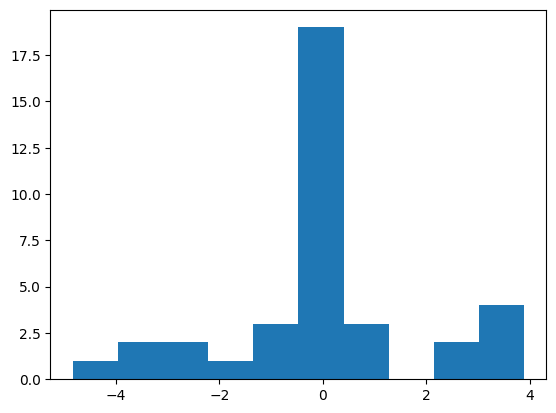

In [ ]:
plt.hist(x)

##### Fitted values

From the model, we can obtain fitted values as:

$$
\hat{y} = \mu + \text{parity} + \text{herd} + \text{u} = \mathbf{Xb} + \mathbf{Zu}
$$

In [ ]:
y_hat = mdf.fittedvalues

There are as many fitted values as records (repeated) in the dataset:

In [ ]:
len(y_hat)

500

(array([14., 14., 37., 59., 89., 94., 88., 44., 44., 17.]),
 array([10.92243138, 12.84669006, 14.77094873, 16.69520741, 18.61946608,
        20.54372476, 22.46798343, 24.39224211, 26.31650078, 28.24075946,
        30.16501813]),
 <BarContainer object of 10 artists>)

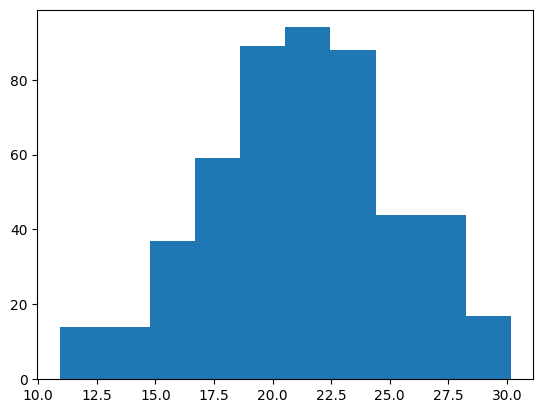

In [ ]:
plt.hist(y_hat)

Correlation between fitted and observed values.

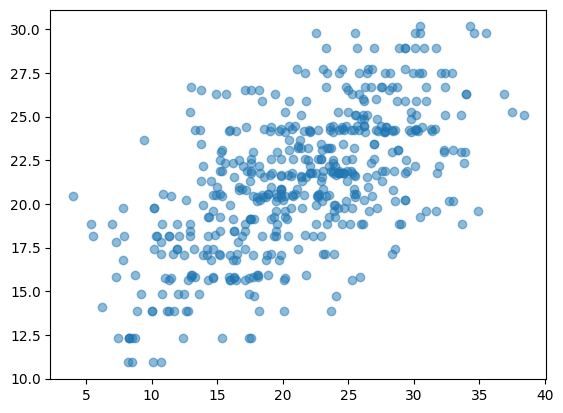

In [ ]:
plt.scatter(cows_reduced['milk'], y_hat, alpha=0.5)
plt.show()

In [ ]:
np.corrcoef(cows_reduced['milk'], y_hat)

array([[1.        , 0.62343493],
       [0.62343493, 1.        ]])

In [ ]:
##sqrt(sum((cows_reduced$milk-y_hat)^2)/nrow(cows_reduced)) ## RMSE
rmse = np.sqrt(((cows_reduced['milk'] - y_hat)**2).sum()/cows_reduced.shape[0])

print(round(rmse, 4))

5.1961


In [ ]:
print("RMSE is", round(rmse/cows_reduced['milk'].mean()*100,3), "% of the average milk production")

RMSE is 24.45 % of the average milk production


The correlation between observed and predicted (fitted) values of the
target variable is one way to measure the **predictive ability** of the
model (and so is the RMSE)

**Q: have we measured correctly the predictive ability of the model?**

### (Cross) Validation

In [ ]:
# Ensure default integer index if needed
y_trn = cows_reduced.reset_index(drop=True).copy()

# Total number of rows
n = len(y_trn)

# Sample 10% of row **positions**
sample_indices = np.random.choice(n, size=int(n / 10), replace=False)

# Set milk to NaN in those rows using iloc
y_trn.iloc[sample_indices, y_trn.columns.get_loc('milk')] = np.nan

In [ ]:
y_trn

,NID,date,herd,parity,milk
0,V1,2015-01-07,2781016,6+,22.7
1,V1,2016-06-07,2781016,6+,20.8
2,V1,2015-02-10,2781016,6+,22.9
3,V1,2016-01-12,2781016,6+,22.9
4,V1,2016-02-16,2781016,6+,NaN
...,...,...,...,...,...
495,V37,2016-10-13,2773233,2,19.9
496,V37,2016-11-18,2773233,2,18.6
497,V37,2015-07-20,2773233,1,15.0
498,V37,2016-03-21,2773233,2,30.2


In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(cows_reduced, test_size=0.1, stratify = cows_reduced['NID'])

In [ ]:
train.shape

(450, 5)

In [ ]:
# Mixed Effects Model
md = sm.formula.mixedlm("milk ~ parity + herd", train,
                        groups=train["NID"]
                        #re_formula="~parity"  # Random intercepts for NID and random slope for parity
)
# Fit the model
mdf = md.fit()

$$
\hat{y} = \mu + \text{parity} + \text{herd} + NID
$$

First, manually for the second test record:

In [ ]:
test.iloc[1,:]

,171
NID,V12
date,2017-03-21 00:00:00
herd,2791352
parity,4
milk,7.3


<u>Systematic effects</u>:

In [ ]:
mdf.params.head()

,0
Intercept,13.392227
parity[T.2],3.339000
parity[T.3],4.762766
parity[T.4],8.255656
parity[T.5],7.153853


In [ ]:
mu = np.array(mdf.params.filter(like='Intercept', axis=0)).item()
parity = np.array(mdf.params.filter(like='parity[T.2]', axis=0)).item()
herd = np.array(mdf.params.filter(like='2774304', axis=0)).item()

print("mu:", mu, "parity:", parity, "herd:", herd)

mu: 13.392226606142781 parity: 3.338999671643789 herd: 9.594030889532961


<u>Random effects</u>:

In [ ]:
rand_eff = mdf.random_effects
len(rand_eff)

37

In [ ]:
nid = np.array([v for k,v in rand_eff.items() if k == "V27"]).item()
print('NID effect is:', nid)

NID effect is: 1.1631208676081364e-14


We now have all the elements to make our prediction:

In [ ]:
pred = mu + parity + herd + nid
print("The prediction for the second test record is:", round(pred, 3))

The prediction for the second test record is: 26.325


---

Now we use `predict()` to make predictions automatically on the entire test set:

In [ ]:
test_d = test.drop('milk', axis=1)

In [ ]:
test_d.head()

,NID,date,herd,parity
74,V6,2016-03-08,2731005,4
171,V12,2017-03-21,2791352,4
432,V34,2016-01-13,2793713,3
1,V1,2016-06-07,2781016,6+
147,V11,2015-09-24,2791319,5


In [ ]:
predictions = mdf.predict(test_d)
predictions.rename("y_hat", inplace=True)
predictions.head()

,y_hat
74,24.400000
171,19.474985
432,15.752707
1,25.158081
147,22.198090


In [ ]:
test = pd.merge(test, predictions, left_index=True, right_index=True)

In [ ]:
test.head()

,NID,date,herd,parity,milk,y_hat
74,V6,2016-03-08,2731005,4,23.6,24.400000
171,V12,2017-03-21,2791352,4,7.3,19.474985
432,V34,2016-01-13,2793713,3,11.0,15.752707
1,V1,2016-06-07,2781016,6+,20.8,25.158081
147,V11,2015-09-24,2791319,5,23.5,22.198090


#### Model evaluation

<Axes: xlabel='milk', ylabel='y_hat'>

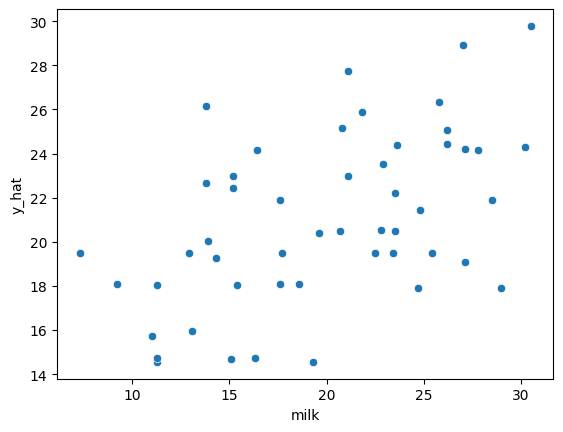

In [ ]:
sns.scatterplot(x="milk", y="y_hat", data=test)

In [ ]:
np.corrcoef(test['milk'], test['y_hat'])

array([[1.        , 0.52080469],
       [0.52080469, 1.        ]])

-----------------------------------------------------------------------

**Q: The correlation between observed and predicted milk production is lower compared to the one that we measured before: why do you think it is so?**

-----------------------------------------------------------------------

Let's calculate other metrics of model performance:

In [ ]:
## function to claculate RMSE

def rmse(y, y_hat):
  n = len(y)
  squared_diff = (y-y_hat)**2
  sumsq = np.sum(squared_diff)
  mse = sumsq/n
  rmse = np.sqrt(mse)

  return rmse

In [ ]:
y = np.array(test['milk'])
y_hat = np.array(test['y_hat'])

rmseval = rmse(y,y_hat)
print(round(rmseval, 3))

5.298


And in the training set?

In [ ]:
train_d = train.drop('milk', axis=1)

In [ ]:
predictions = mdf.predict(train_d)
predictions.rename("y_hat", inplace=True)

,y_hat
288,24.149455
76,24.400000
112,28.921971
494,20.975182
300,29.783333
...,...
13,18.047510
79,24.400000
405,17.894118
232,14.558328


In [ ]:
train = pd.merge(train, predictions, left_index=True, right_index=True)

<Axes: xlabel='milk', ylabel='y_hat'>

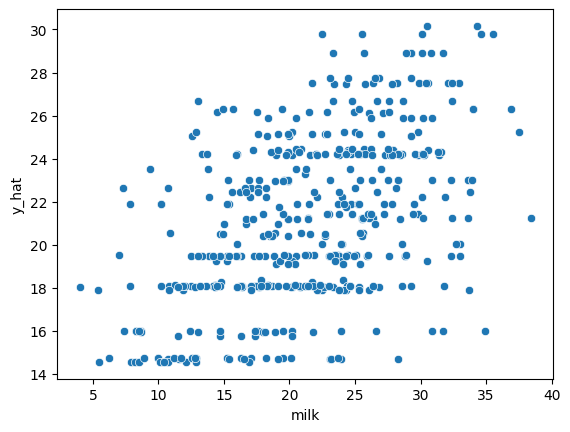

In [ ]:
sns.scatterplot(x="milk", y="y_hat", data=train)

In [ ]:
np.corrcoef(train['milk'], train['y_hat'])

array([[1.        , 0.50587927],
       [0.50587927, 1.        ]])

In [ ]:
y = np.array(train['milk'])
y_hat = np.array(train['y_hat'])

rmseval = rmse(y,y_hat)
print(round(rmseval, 3))

5.797


---

## Exercise: can you improve the model?

What about the use of `herd` or `parity`? (categorical variables)

Can we use continuous predictors?


In [ ]:
## your code here